In [1]:
import numpy as np
from load_mnist import load_mnist
import matplotlib.pyplot as plt


In [2]:
# Load the data
X_train, Y_train, X_test, Y_test = load_mnist()

In [3]:
print("X_train.shape = ", X_train.shape)
print("Y_train.shape = ", Y_train.shape)
print("X_test.shape = ", X_test.shape)
print("Y_test.shape = ", Y_test.shape)

X_train.shape =  (60000, 784)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 784)
Y_test.shape =  (10000, 10)


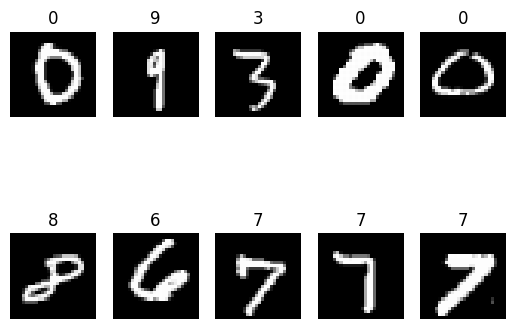

In [4]:
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]

# Plot the first 10 images in the training set
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(np.argmax(Y_train[i]))
    plt.axis('off')
plt.show()


In [5]:
class NeuralNetwork:
    def __init__(self, hidden_size=10, eta=0.05, epochs=1000,
                 l2=0.5,
                 minibatches=100,
                 activation='sigmoid',
                 random_seed=None):

        self.hidden_size = hidden_size
        self.eta = eta
        self.epochs = epochs
        self.l2 = l2
        self.activation = activation
        self.minibatches = minibatches
        self.random_seed = random_seed
        self.cost_train_ = []
        self.cost_test_  = []
        self.acc_train_  = []
        self.acc_test_   = []

    
    def _init_params(self, weights_1_shape, bias_1_shape, 
                    weights_2_shape, bias_2_shape,
                    dtype='float64', scale=0.01, random_seed=None):
        """Initialize weight coefficients."""
        if random_seed:
            np.random.seed(random_seed)
        self.W1 = np.random.normal(loc=0.0, scale=scale, size=weights_1_shape)
        self.b1 = np.zeros(shape=bias_1_shape, dtype=dtype)
        self.W2 = np.random.normal(loc=0.0, scale=scale, size=weights_2_shape)
        self.b2 = np.zeros(shape=bias_2_shape, dtype=dtype)
        return self

    def sigmoid(self, x):
        x = np.clip(x, -500, 500 )
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)
        #return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    
        # Calculating softmax for all examples.
        for i in range(len(x)):
            exp[i] /= np.sum(exp[i])
        
        return exp

    
    def forward(self, X):
        self.z1 = self.linear_forward(X, self.W1, self.b1)
        self.a1 = self.sigmoid(self.z1) if self.activation == 'sigmoid' else self.relu(self.z1)
        self.z2 = self.linear_forward(self.a1, self.W2, self.b2)
        self.a2 = self.softmax(self.z2)
        return self.a2

    def linear_forward(self, X, W, b):
        return X.dot(W) + b

    def compute_cost(self, X, y):
        output = self.predict(X)
        cross_ent = self._cross_entropy(output=output, y_target=y)
        cost = self._cost(cross_ent)
        return cost

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output + 1e-15) * (y_target), axis=1) #+ 1e-15

    def _cost(self, cross_entropy):
        L2_term = self.l2 * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)

    def backward(self, X, Y, output):
        self.output_error = output - Y
        self.output_delta = self.output_error
        self.z1_error = self.output_delta.dot(self.W2.T)
        self.z1_delta = self.z1_error * (self.sigmoid_derivative(self.a1) if self.activation == 'sigmoid' else self.relu_derivative(self.a1))
        self.dw2 = self.a1.T.dot(self.output_delta) / X.shape[0]
        self.db2 = np.sum(self.output_delta, axis=0, keepdims=False) / X.shape[0]
        self.dw1 = X.T.dot(self.z1_delta) / X.shape[0]
        self.db1 = np.sum(self.z1_delta, axis=0, keepdims=False) / X.shape[0]
    
    def update_parameters(self):
        self.W2 += -self.eta * (self.dw2 + self.l2 * self.W2)
        self.b2 += -self.eta * self.db2
        self.W1 += -self.eta * (self.dw1 + self.l2 * self.W1)
        self.b1 += -self.eta * self.db1
    

    def train(self, X, Y, X_test, Y_test):
        features = X.shape[1]
        n_classes = Y.shape[1]
        self._init_params(
            weights_1_shape=(features, self.hidden_size),
            bias_1_shape=(self.hidden_size,),
            weights_2_shape=(self.hidden_size, n_classes),
            bias_2_shape=(n_classes,),
            random_seed=self.random_seed)
        # Compute accuracy
        acc_train = self.accuracy(X, Y)
        acc_test = self.accuracy(X_test, Y_test)
        self.acc_train_.append(acc_train)
        self.acc_test_.append(acc_test)

        # Compute cost
        cost_train = self.compute_cost(X, Y)
        cost_test = self.compute_cost(X_test, Y_test)
        self.cost_train_.append(cost_train)
        self.cost_test_.append(cost_test)
        print(f'Epoch: {0} | Lost: {cost_train:.4f} | Train Acc.: {acc_train:.3f}% | Test Acc.: {acc_test:.3f}%')
        
        for epoch in range(self.epochs):
            for idx in self._yield_minibatches_idx(
                    n_batches=self.minibatches,
                    data_ary=Y,
                    shuffle=True):
                # Forward propagation
                output = self.forward(X[idx])


                # Backpropagation
                self.backward(X[idx], Y[idx], output)
                # Update weights
                self.update_parameters()

            # Compute accuracy
            acc_train = self.accuracy(X, Y)
            acc_test = self.accuracy(X_test, Y_test)
            self.acc_train_.append(acc_train)
            self.acc_test_.append(acc_test)

            # Compute cost
            cost_train = self.compute_cost(X, Y)
            cost_test = self.compute_cost(X_test, Y_test)
            self.cost_train_.append(cost_train)
            self.cost_test_.append(cost_test)
            
            print(f'Epoch: {epoch+1} | Lost: {cost_train:.4f} | Train Acc.: {acc_train:.3f}% | Test Acc.: {acc_test:.3f}%')

    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
        indices = np.arange(data_ary.shape[0])

        if shuffle:
            indices = np.random.permutation(indices)
        if n_batches > 1:
            remainder = data_ary.shape[0] % n_batches

            if remainder:
                minis = np.array_split(indices[:-remainder], n_batches)
                minis[-1] = np.concatenate((minis[-1],
                                            indices[-remainder:]),
                                            axis=0)
            else:
                minis = np.array_split(indices, n_batches)
        else:
            minis = (indices,)

        for idx_batch in minis:
            yield idx_batch

    def predict(self, X):
        z1 = self.linear_forward(X, self.W1, self.b1)
        a1 = self.sigmoid(z1) if self.activation == 'sigmoid' else self.relu(z1)
        z2 = self.linear_forward(a1, self.W2, self.b2)
        a2 = self.softmax(z2)
        return a2
        
    def accuracy(self, X, y_target):
        y_pred = self.predict(X)
        return 100.0 * np.sum(y_pred.argmax(axis=1)==y_target.argmax(axis=1))/len(X) #accuracy score in percentage

In [6]:
nn = NeuralNetwork(epochs=100, eta=0.1, hidden_size=50, minibatches=200, l2=0, random_seed=2, activation='relu')
nn.train(X_train, Y_train, X_test, Y_test)

Epoch: 0 | Lost: 1.1515 | Train Acc.: 7.175% | Test Acc.: 6.910%
Epoch: 1 | Lost: 0.2765 | Train Acc.: 85.068% | Test Acc.: 85.810%
Epoch: 2 | Lost: 0.1912 | Train Acc.: 89.348% | Test Acc.: 89.620%
Epoch: 3 | Lost: 0.1655 | Train Acc.: 90.693% | Test Acc.: 90.920%
Epoch: 4 | Lost: 0.1535 | Train Acc.: 91.280% | Test Acc.: 91.610%
Epoch: 5 | Lost: 0.1424 | Train Acc.: 91.958% | Test Acc.: 92.100%
Epoch: 6 | Lost: 0.1348 | Train Acc.: 92.362% | Test Acc.: 92.670%
Epoch: 7 | Lost: 0.1273 | Train Acc.: 92.770% | Test Acc.: 92.970%
Epoch: 8 | Lost: 0.1209 | Train Acc.: 93.250% | Test Acc.: 93.340%
Epoch: 9 | Lost: 0.1156 | Train Acc.: 93.570% | Test Acc.: 93.630%
Epoch: 10 | Lost: 0.1096 | Train Acc.: 93.885% | Test Acc.: 93.880%
Epoch: 11 | Lost: 0.1037 | Train Acc.: 94.178% | Test Acc.: 94.140%
Epoch: 12 | Lost: 0.0991 | Train Acc.: 94.517% | Test Acc.: 94.380%
Epoch: 13 | Lost: 0.0942 | Train Acc.: 94.742% | Test Acc.: 94.720%
Epoch: 14 | Lost: 0.0906 | Train Acc.: 94.952% | Test Acc.: 

In [12]:
idx = np.arange(X_test.shape[0])
np.random.shuffle(idx)
X_test_shuffled = X_test[idx]
Y_test_shuffled = Y_test[idx]

y_pred=nn.predict(X_test_shuffled)
acc = np.sum(y_pred.argmax(axis=1)==Y_test_shuffled.argmax(axis=1))/len(X_test_shuffled)*100
print('Test accuracy: {:.2f}%'.format(acc))


Test accuracy: 97.28%


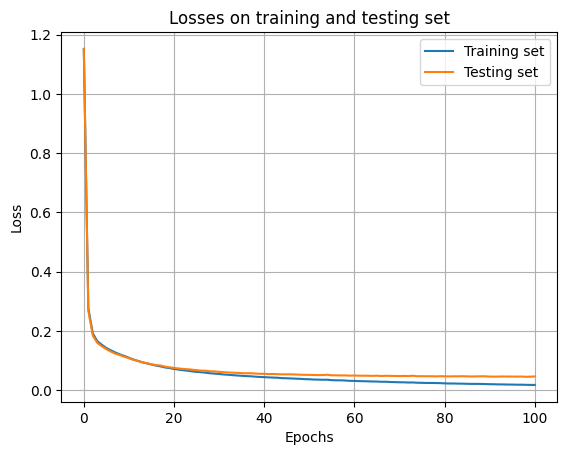

In [13]:
fig = plt.figure()
plt.plot(range(len(nn.cost_train_)), nn.cost_train_, label='Training set')

plt.plot(range(len(nn.cost_test_)), nn.cost_test_, label='Testing set')
plt.title('Losses on training and testing set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()
fig.savefig('losses_nn.png')

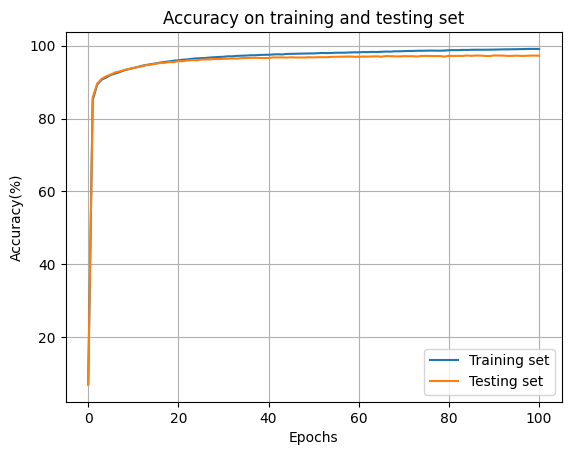

In [14]:
fig = plt.figure()
plt.plot(range(len(nn.acc_train_)), nn.acc_train_, label='Training set')
plt.plot(range(len(nn.acc_test_)), nn.acc_test_, label='Testing set')
plt.title('Accuracy on training and testing set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
fig.savefig('accuracy_nn.png')

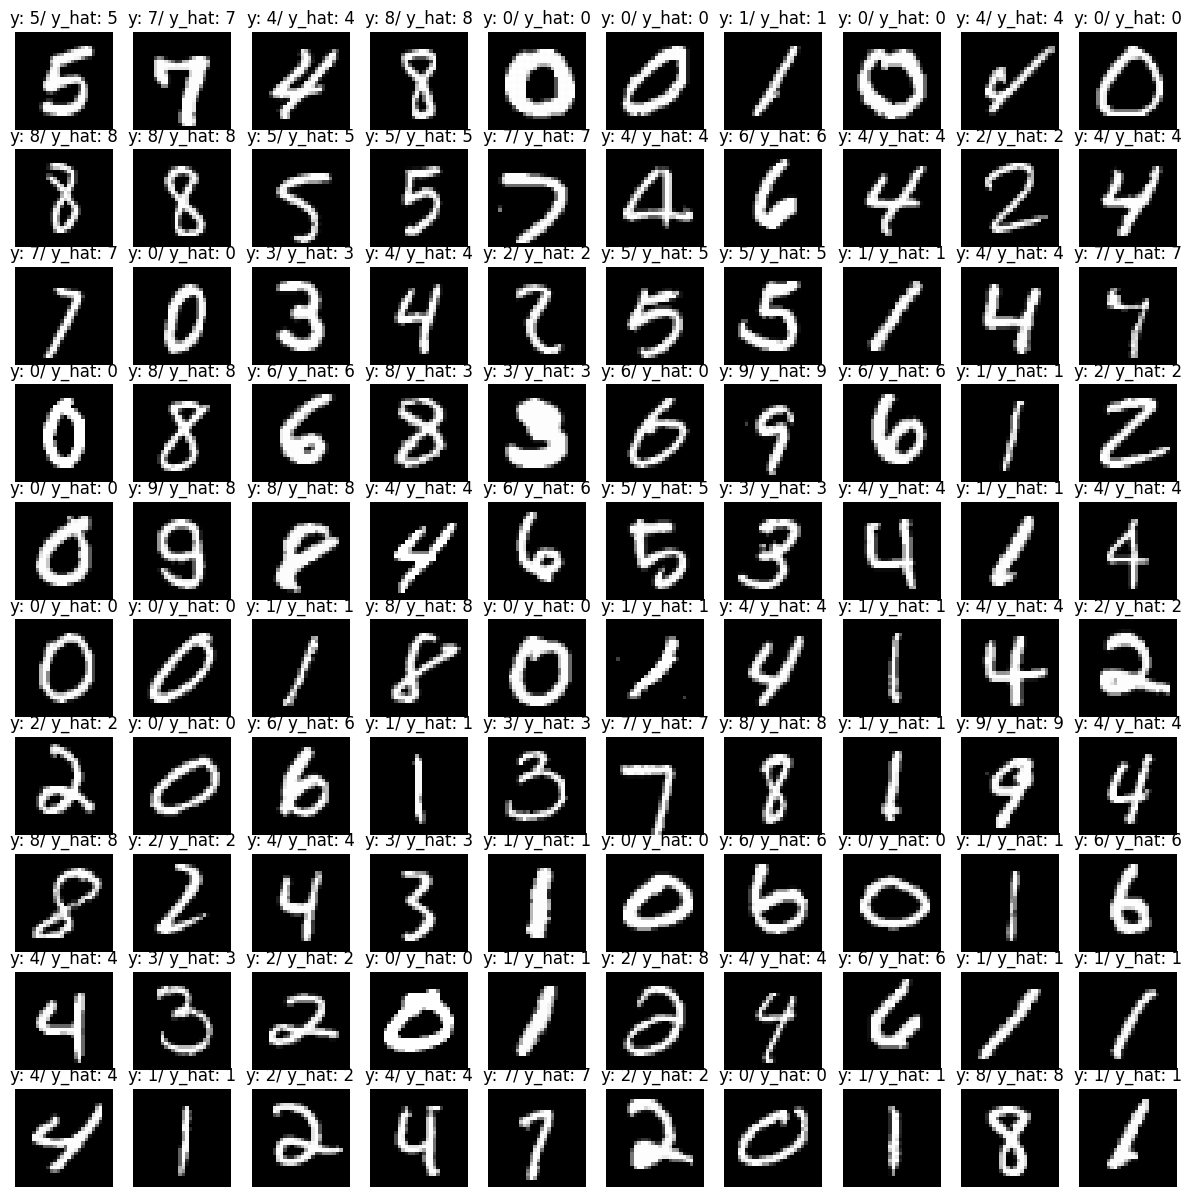

0.96


In [15]:
fig = plt.figure(figsize=(15,15))
count= 0
for i in range(100):  
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(X_test_shuffled[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    
    ax.set_title('y: {y}/ y_hat: {y_hat}'
                 .format(y=Y_test_shuffled[i].argmax(), y_hat=y_pred[i].argmax()))
    if Y_test_shuffled[i].argmax() == y_pred[i].argmax():
        count = count + 1
    plt.axis('off')
plt.show()
print(count/100)

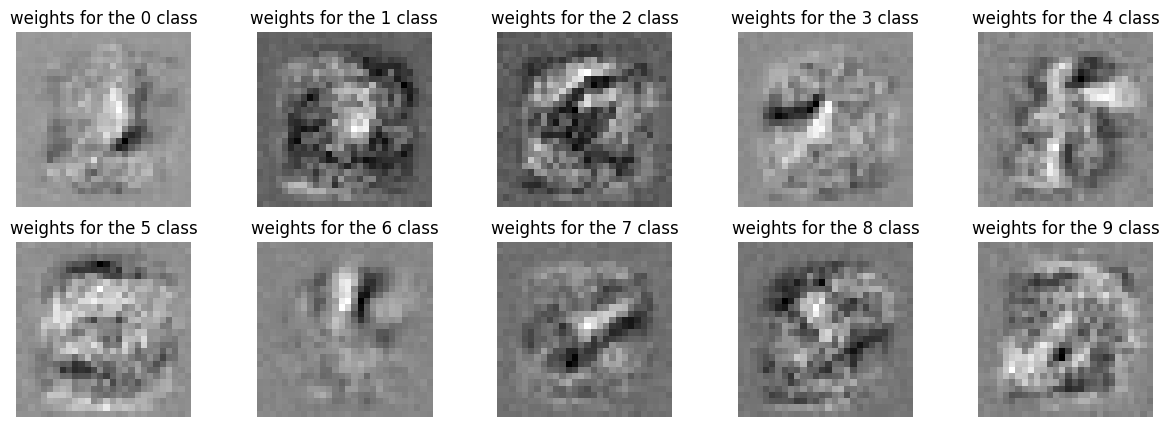

In [16]:
fig = plt.figure(figsize=(15,5))
for i in range(10):  
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(nn.W1[:,i].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax.set_title('weights for the {i} class'.format(i=i))
    plt.axis('off')
plt.show()
